In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar


from utils import geometry
from utils import fileio

In [3]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental\\20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP\\5min_int/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental\\20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP\\5min_int/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental\\20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP\\5min_int/tm_edges.csv', skiprows=[1,2,3])

In [4]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20231005_1_IP_GFPCAAX-CheHis_us_*/*/Data/*_cell_data_geometry.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/20231005_1_IP_GFPCAAX-CheHis_us_*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_plots\\20231005_1_IP_GFPCAAX-CheHis_us_8p6/'

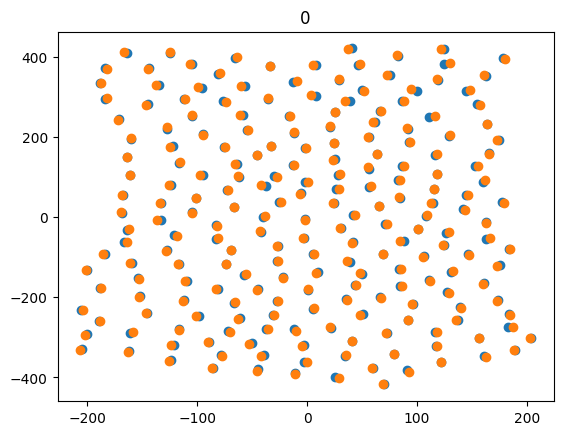

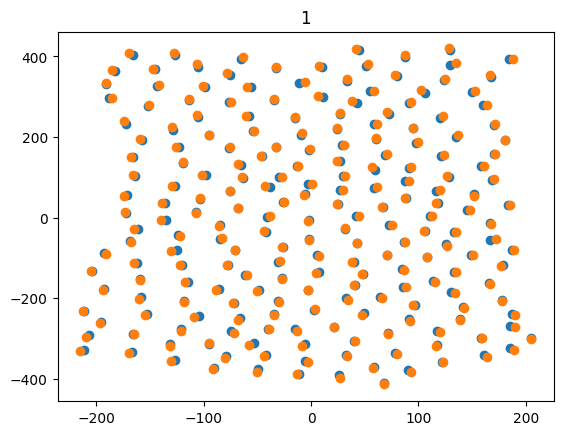

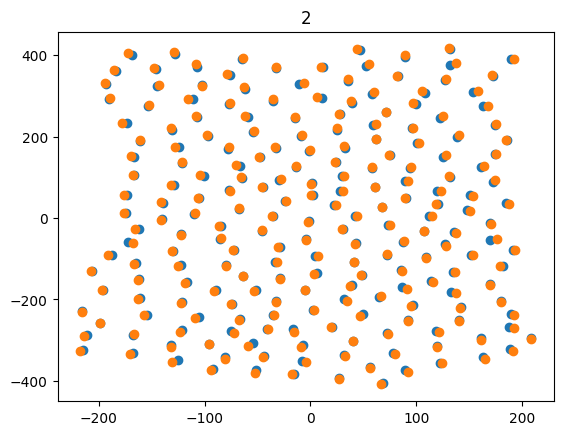

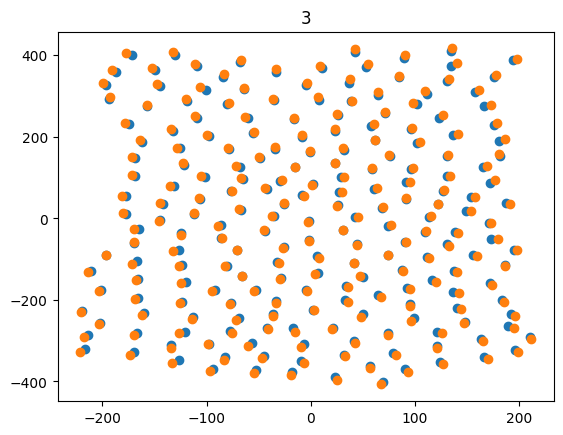

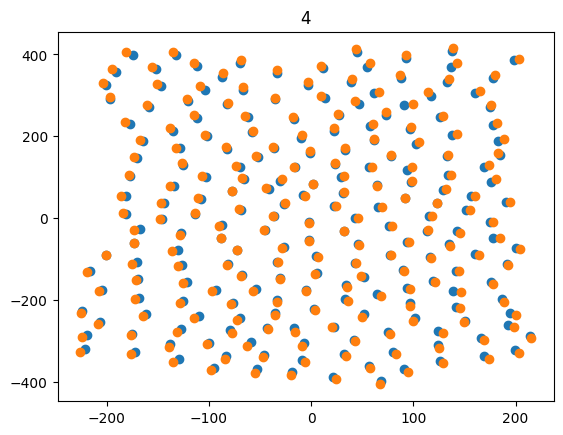

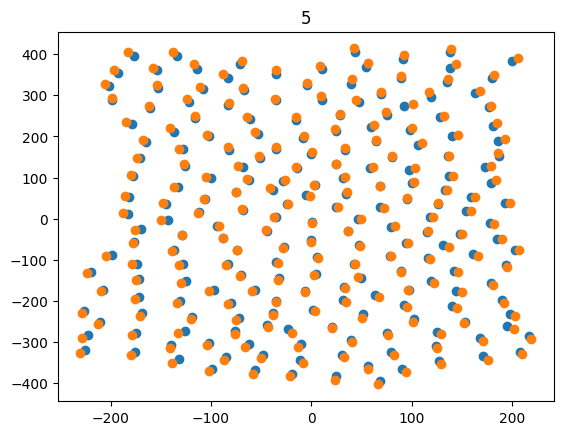

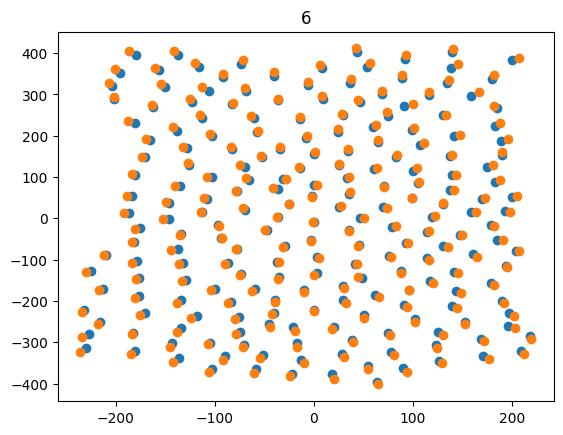

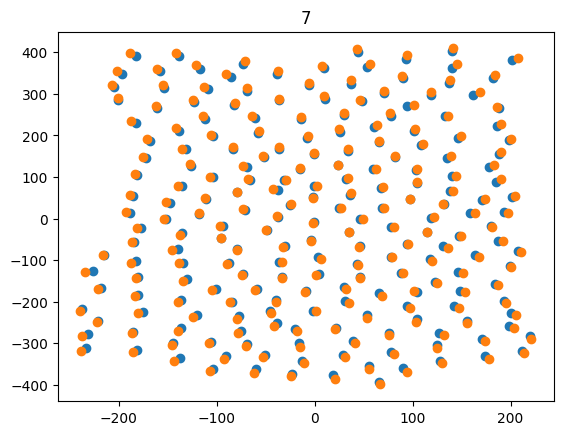

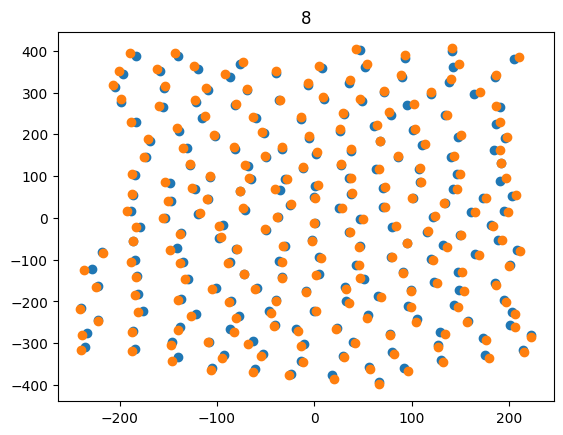

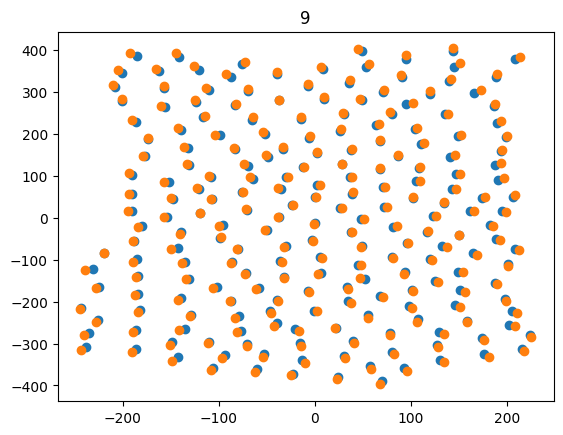

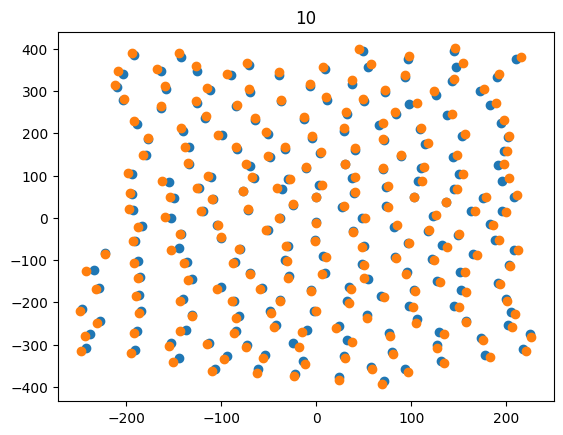

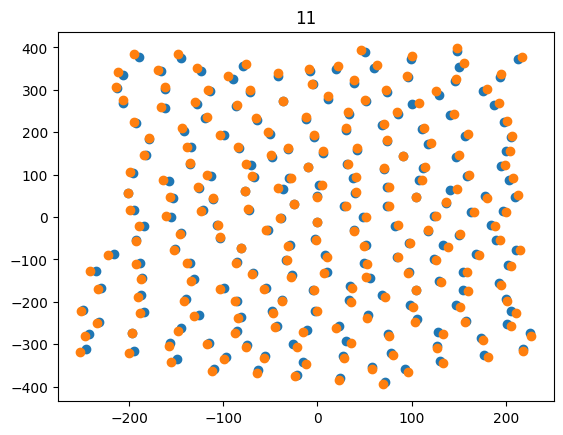

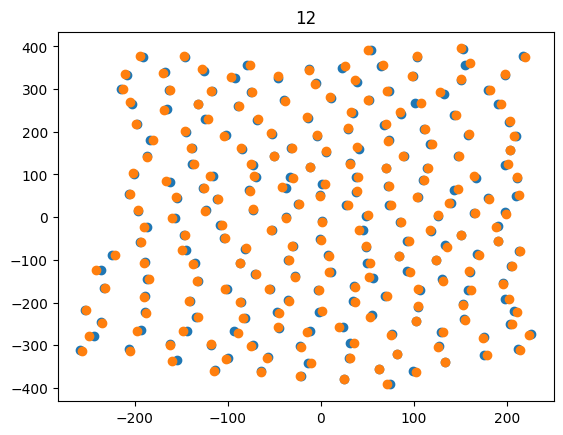

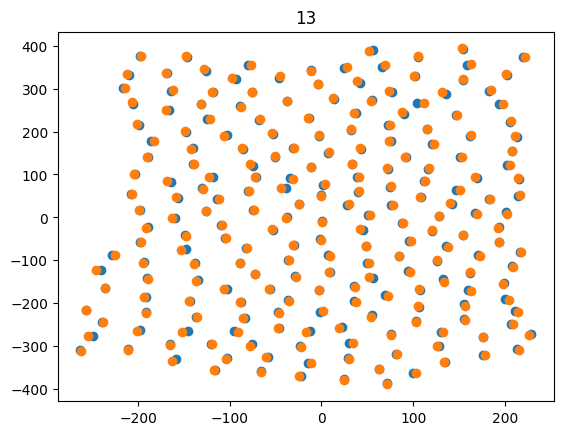

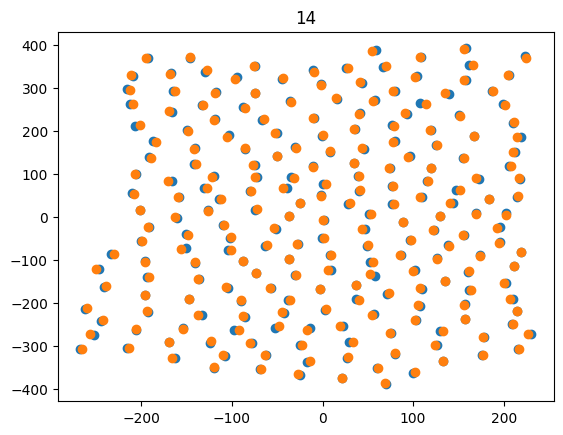

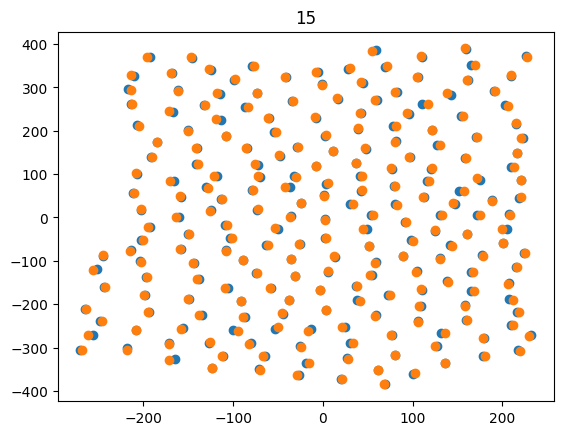

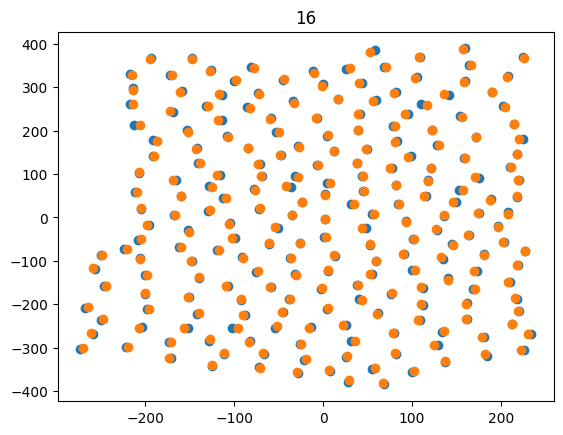

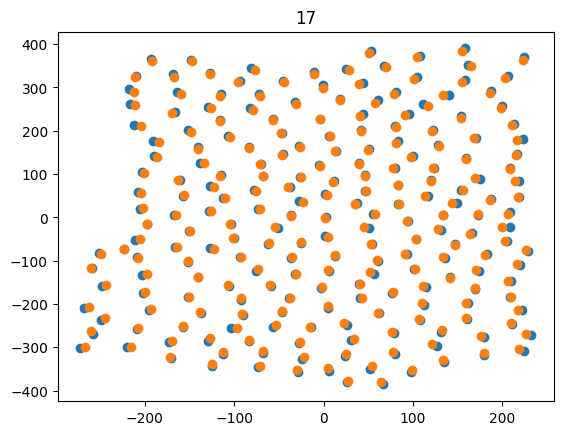

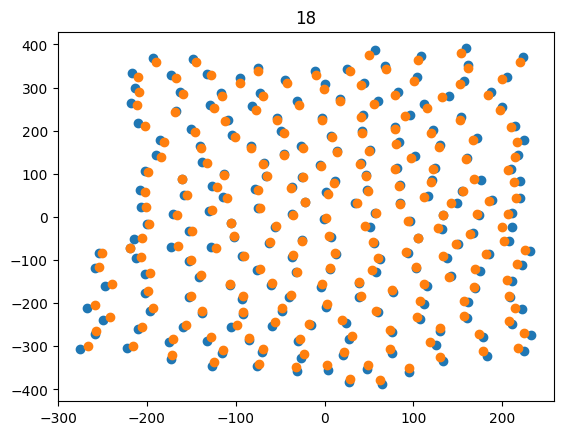

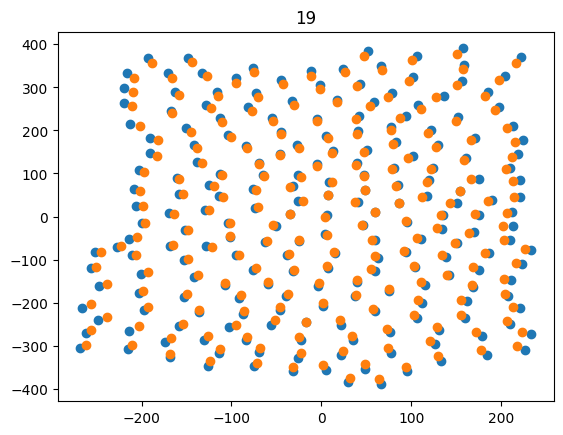

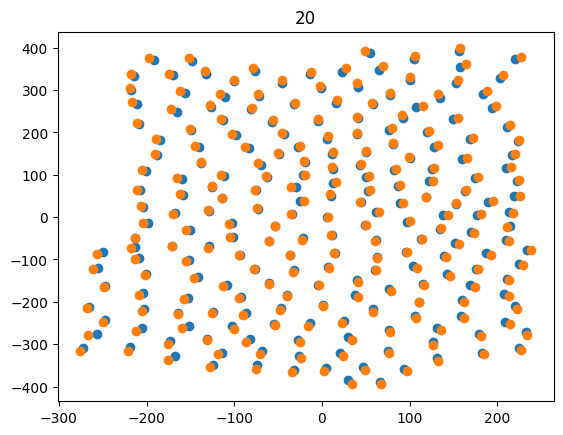

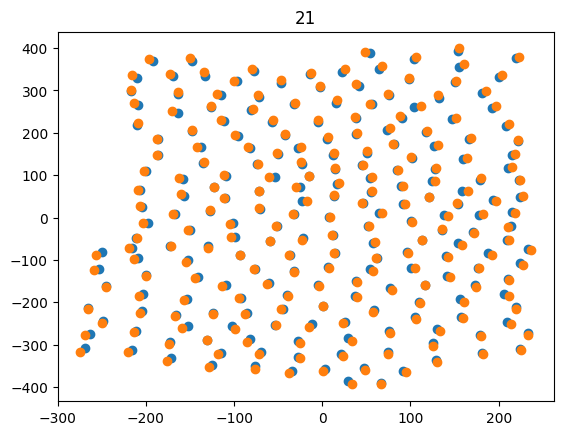

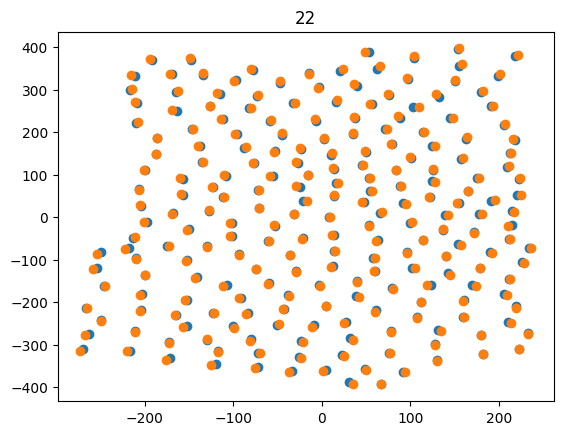

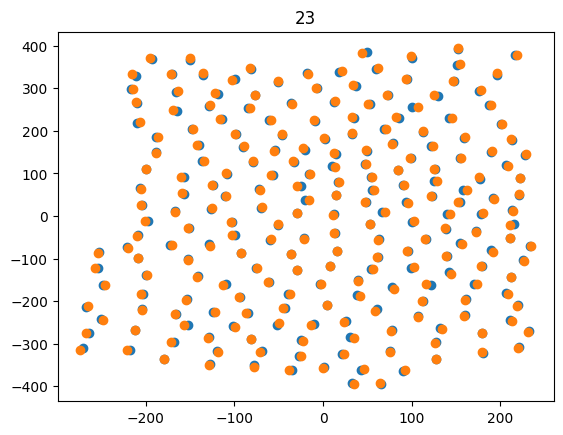

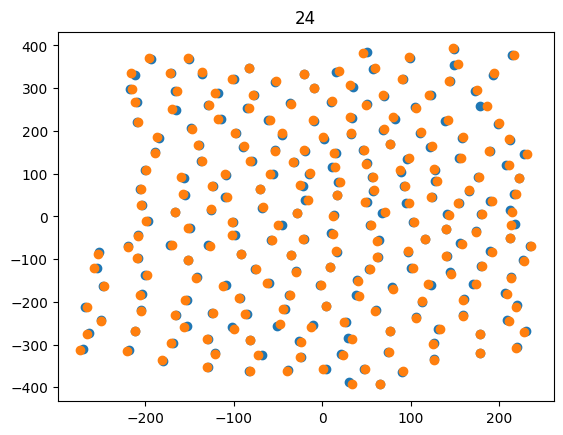

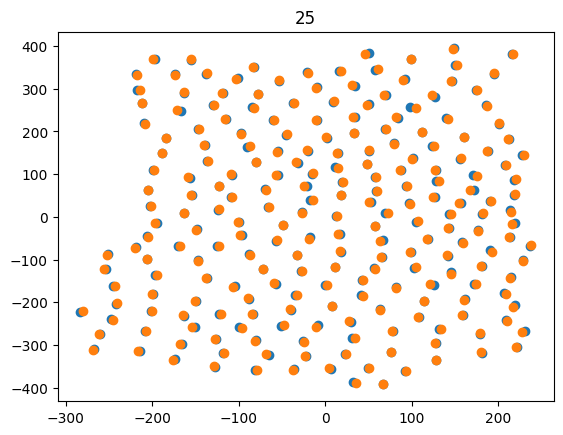

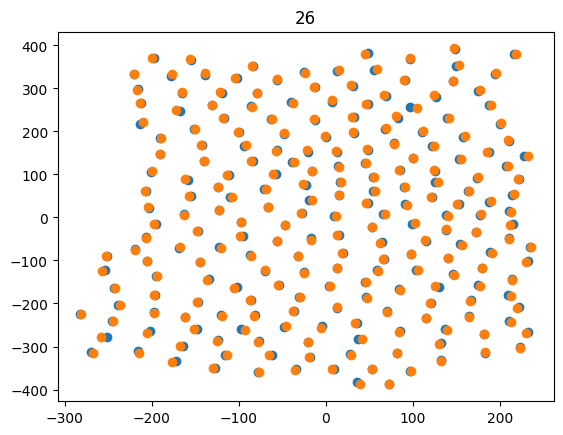

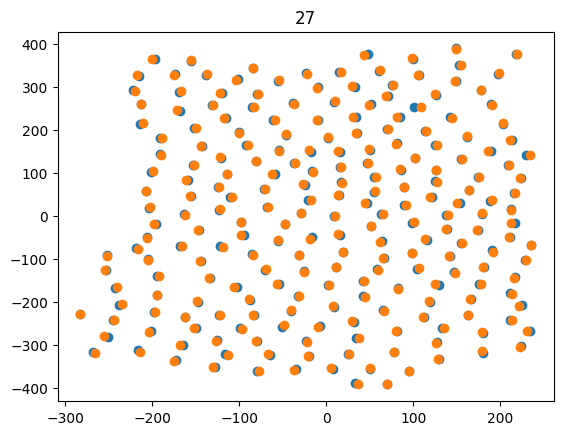

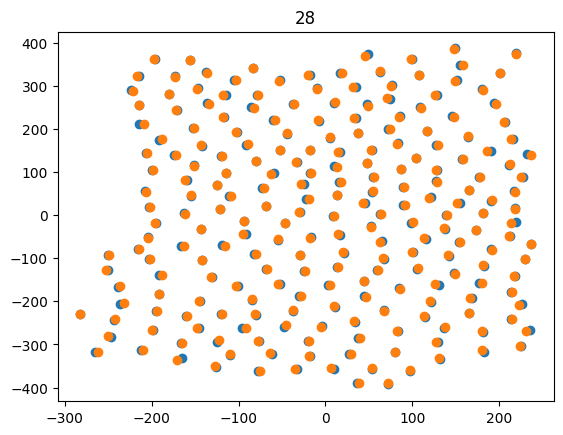

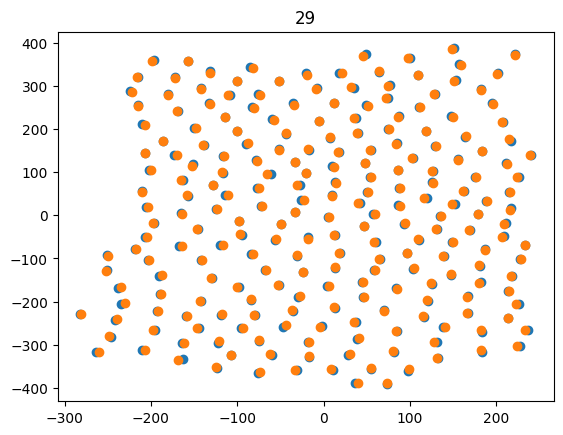

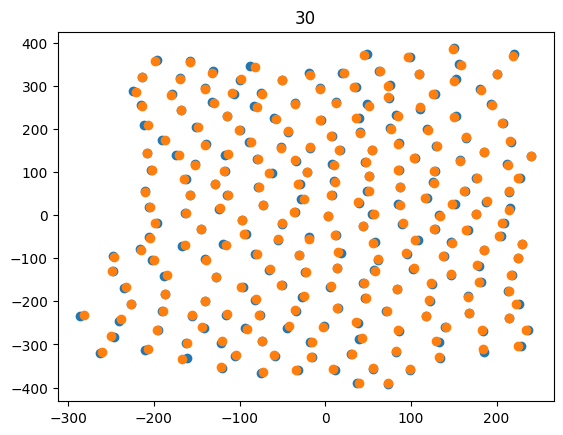

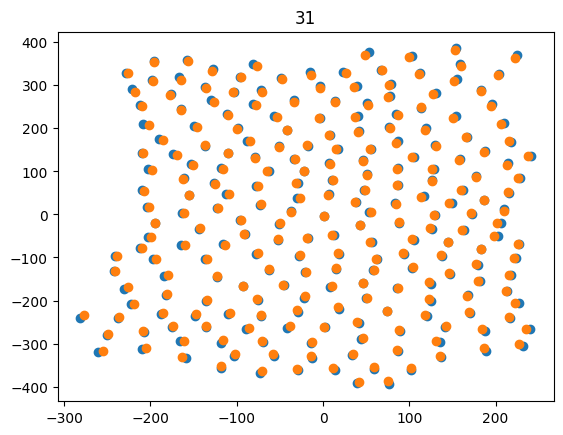

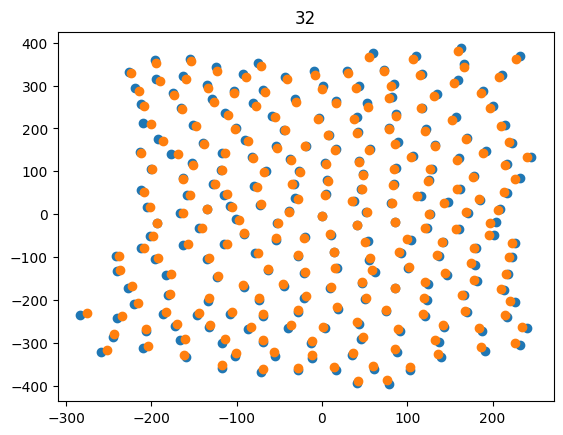

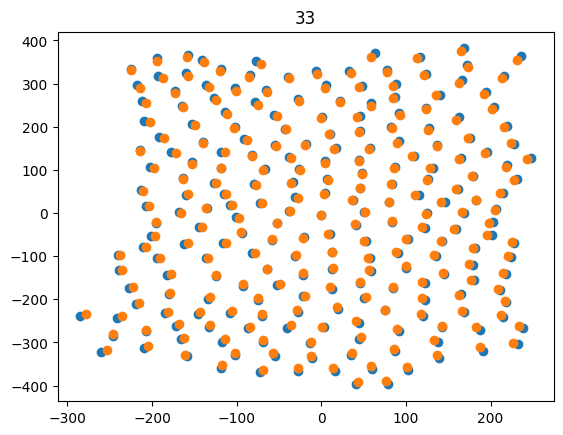

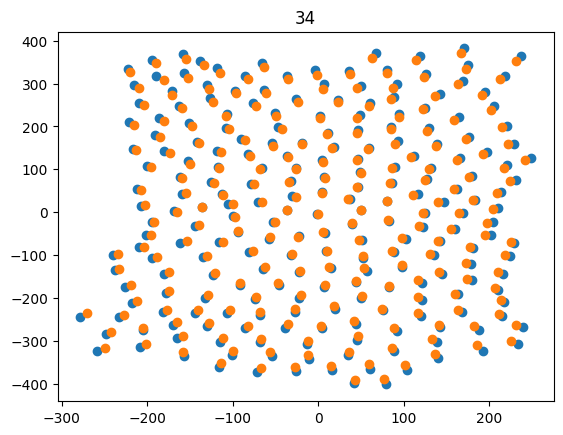

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_30184\105092133.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.loc[index_a]=t_id+1
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_30184\105092133.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.loc[index_b]=t_id+2
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_30184\105092133.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_df.track_id.loc

In [5]:
cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    if i<20:
        scale_factor=0.72-0.0035*i
    else:
        scale_factor=0.725-0.0018*i

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    plt.scatter(cc[:,0], cc[:,1])
    plt.scatter(tm_cc[:,0], tm_cc[:,1])
    plt.title(str(i))
    plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


t_id=np.max(dat_df.track_id)
Nc_orig=t_id
for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]

    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
    dat_df.track_id.loc[index_a]=t_id+1
    track_b=[]
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
    dat_df.track_id.loc[index_b]=t_id+2
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=n_edges[n_edges.SPOT_SOURCE_ID==track_a[-1]].SPOT_TARGET_ID.iloc[0]
        t_b=n_edges[n_edges.SPOT_SOURCE_ID==track_b[-1]].SPOT_TARGET_ID.iloc[0]
        track_a.append(t_a)
        track_b.append(t_b)
        index_a=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_a[-1])].index[0]
        index_b=dat_df[(dat_df.track_id==s)&(dat_df.spot_id==track_b[-1])].index[0]
        dat_df.track_id.loc[index_a]=t_id+1
        dat_df.track_id.loc[index_b]=t_id+2
    t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df.to_csv(save_folder+"/20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP_pooled.csv",index=False)

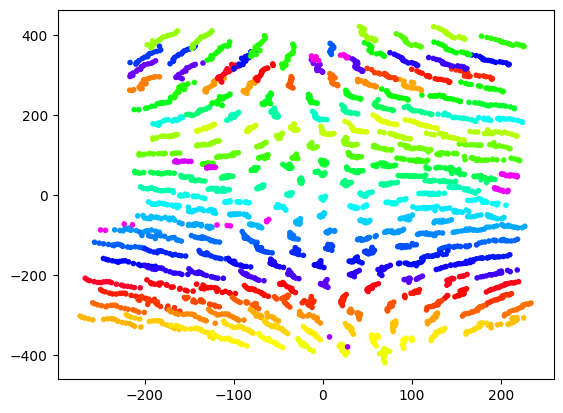

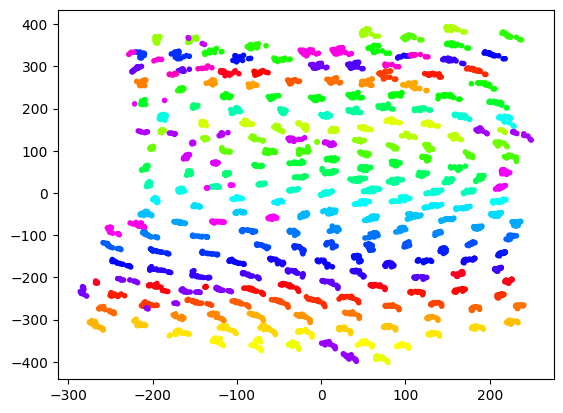

In [81]:
for i in range(17):
    plt.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))
plt.show()


for i in range(17, 35):
    plt.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))


In [67]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

array([  0,   7,  18,  56,  68,  72,  74,  76,  78,  90, 106, 122, 131,
       159, 166, 176, 182, 199, 210], dtype=int64)

In [7]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]

In [12]:
dat_df[dat_df.time==0].count()

cell_id_old                        213
cell_perimeter_microns             213
cell_area_microns                  213
shape_parameter                    213
circularity                        213
cell_edge_count                    213
major_shape_axis_alignment_rads    213
cc_x                               213
cc_y                               213
cell_id_new                        213
spot_id                            213
time                               213
tm_frame                           213
angle_horizontal                   213
dtype: int64

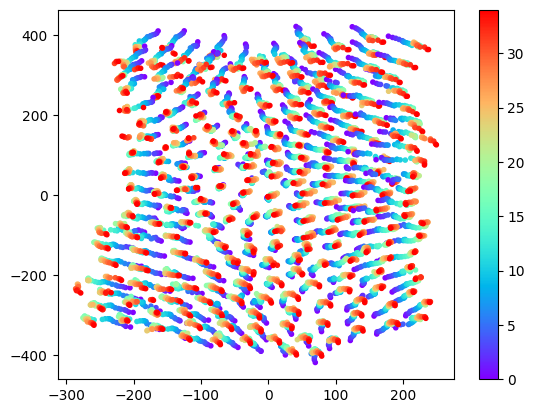

In [83]:
for i in range(np.max(dat_df.cell_id_new)):
    plt.scatter(dat_df[dat_df.cell_id_new==i].cc_x, dat_df[dat_df.cell_id_new==i].cc_y, marker='.', c=dat_df[dat_df.cell_id_new==i].tm_frame, cmap='rainbow', vmin=0, vmax=34)
plt.colorbar()

In [10]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t80=no_div[no_div.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t170=no_div[no_div.tm_frame==34][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
cc_us=pd.merge(nd_t0, nd_t80, on='cell_id_new', suffixes=("_u", "_s"))
cc_us['cc_dx']=cc_us.cc_x_s-cc_us.cc_x_u
cc_us['cc_dy']=cc_us.cc_y_s-cc_us.cc_y_u

cc_sr=pd.merge(nd_t80, nd_t170, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s

cc_0=np.transpose(np.vstack((cc_us.cc_x_u, cc_us.cc_y_u)))
cc_80=np.transpose(np.vstack((cc_us.cc_x_s, cc_us.cc_y_s)))
aft=np.array(cv2.estimateAffine2D(cc_0, cc_80, method=cv2.RANSAC)[0][:,:2])
polar(aft)

(array([[ 0.99955578,  0.02980352],
        [-0.02980352,  0.99955578]]),
 array([[1.25766549, 0.0233753 ],
        [0.0233753 , 0.91715339]]))

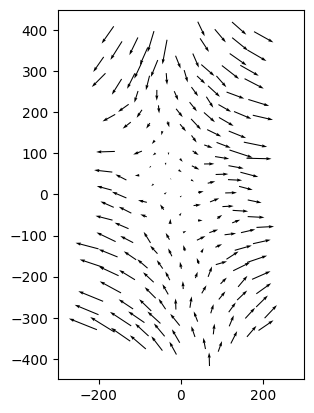

In [85]:
dx= cc_us.cc_dx
dy=cc_us.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_us.cc_x_u,cc_us.cc_y_u, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
plt.xlim(-300,300)
plt.ylim(-450,450)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_stretch.png', dpi=300, bbox_inches='tight')

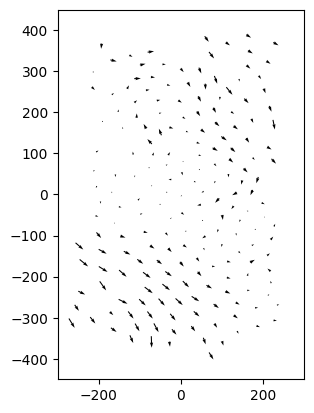

In [86]:
dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-300,300)
plt.ylim(-450,450)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_relaxation.png', dpi=300, bbox_inches='tight')

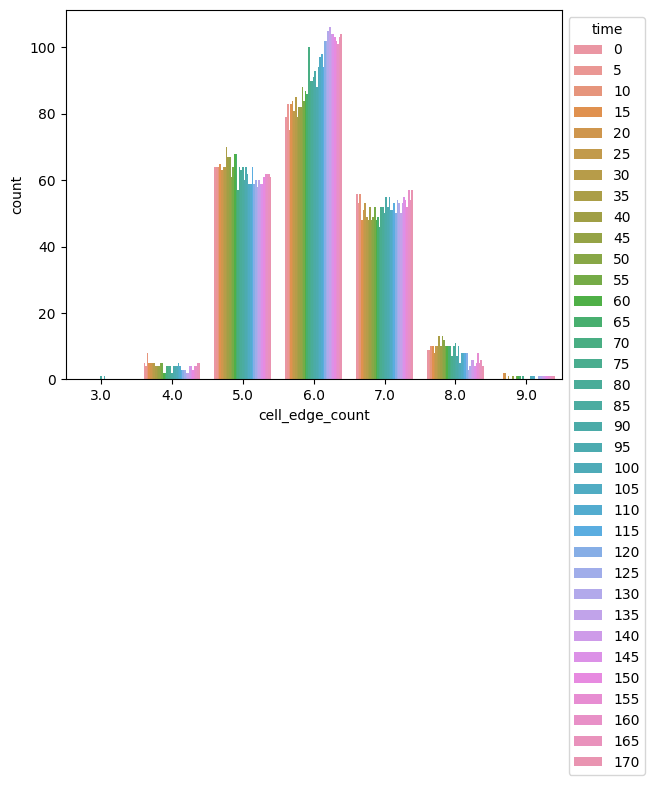

In [87]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

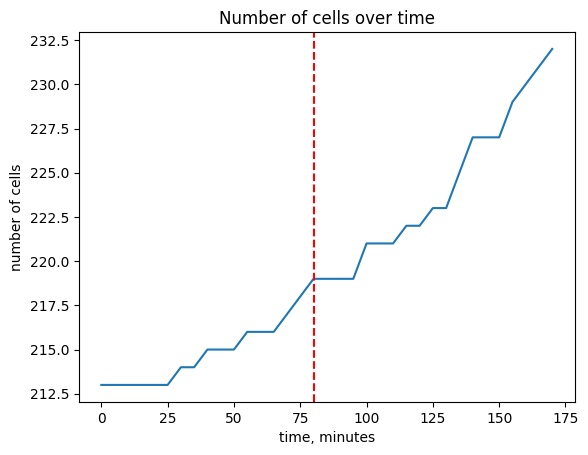

In [88]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

In [74]:
dat_df.time

0         0
1         0
2         0
3         0
4         0
       ... 
7686    170
7687    170
7688    170
7689    170
7690    170
Name: time, Length: 7691, dtype: object

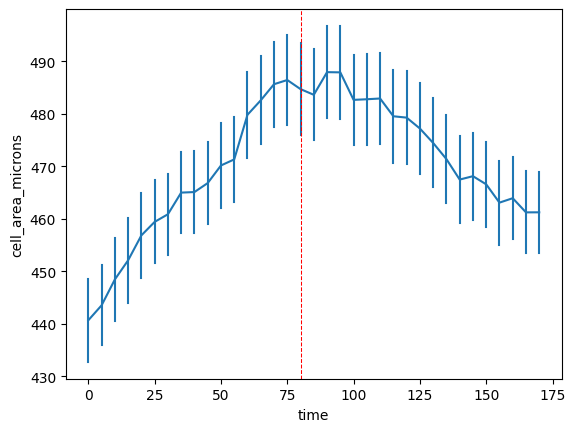

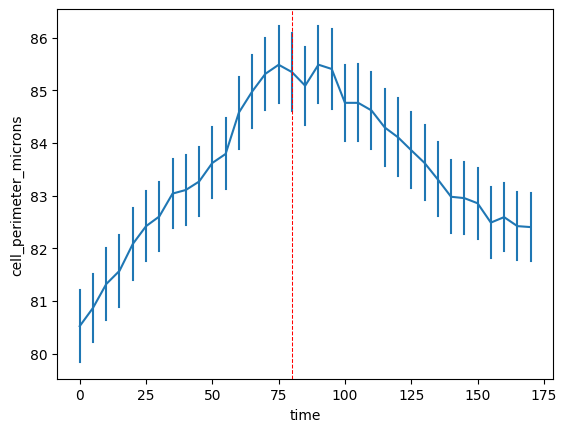

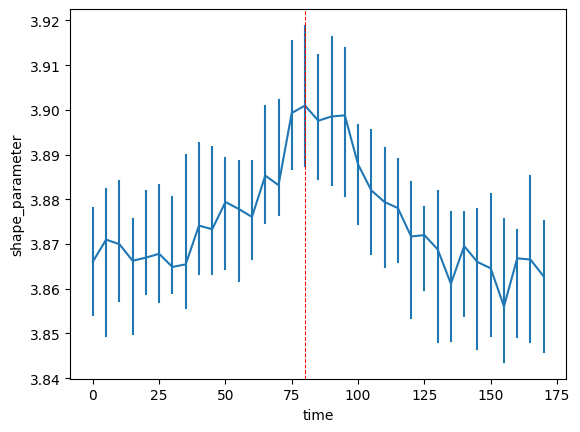

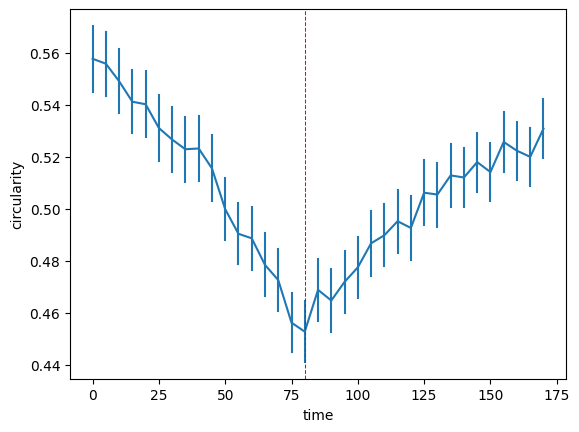

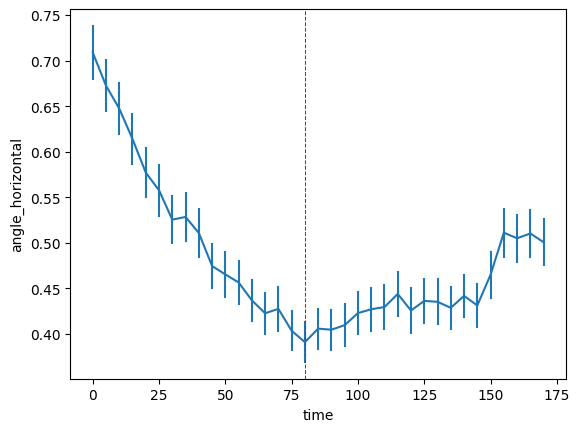

In [89]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

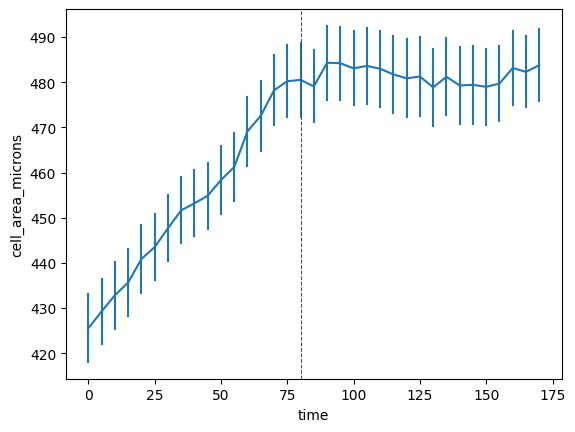

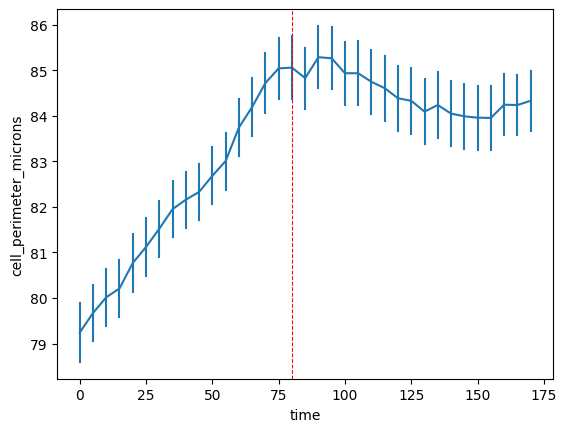

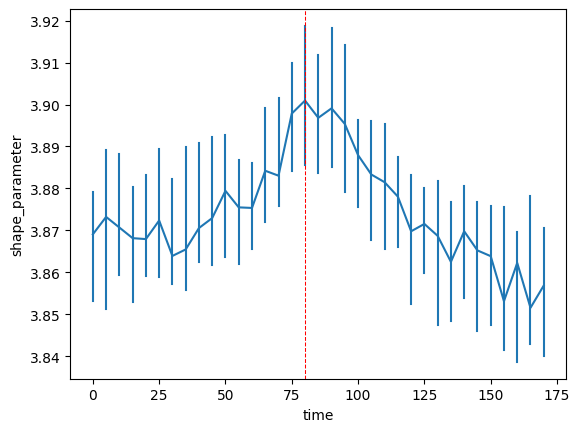

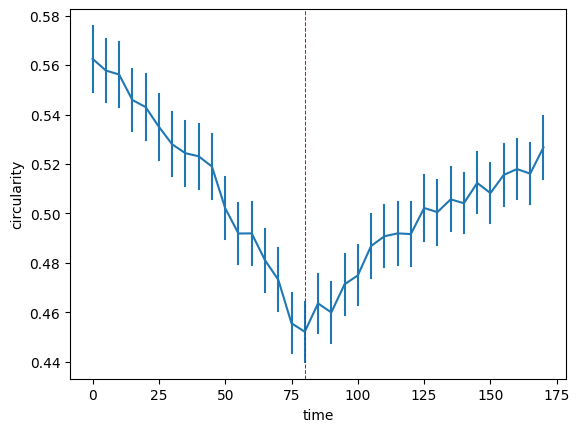

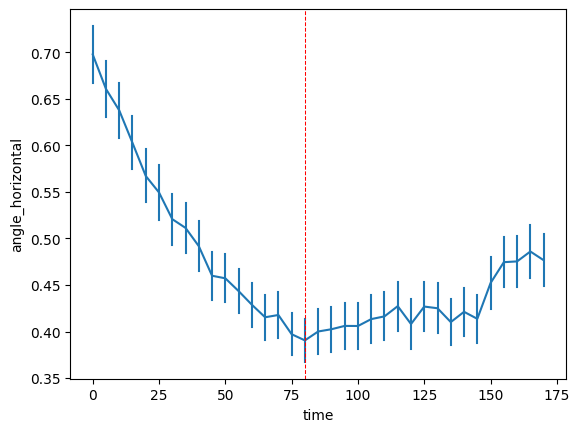

In [90]:
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/no_div_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

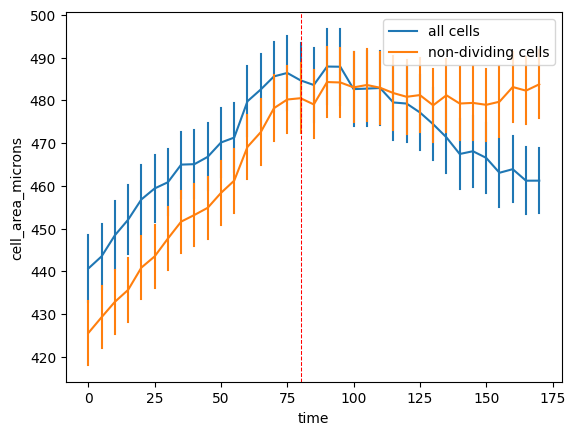

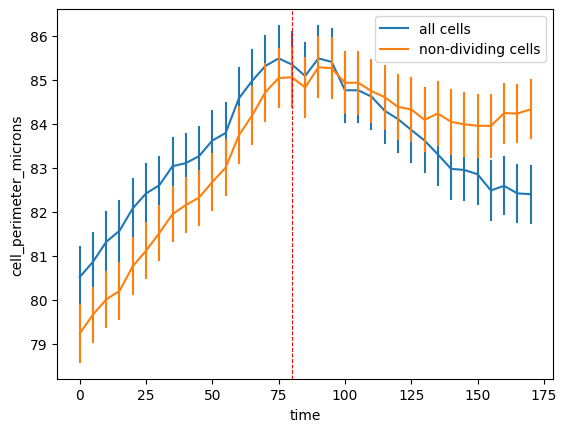

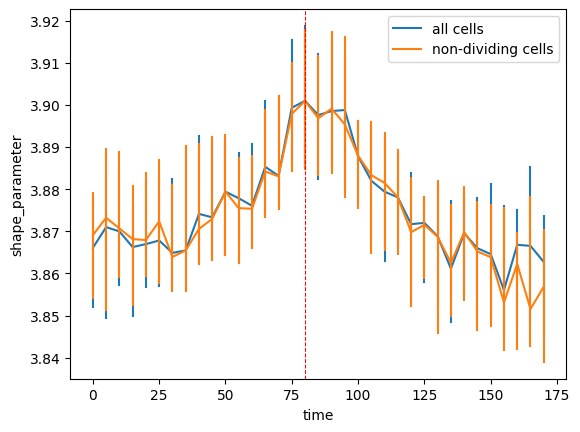

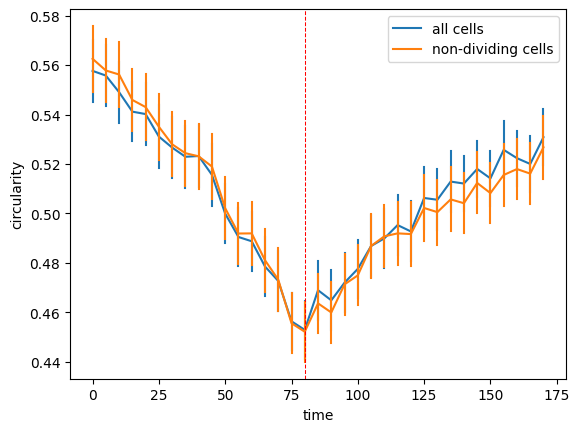

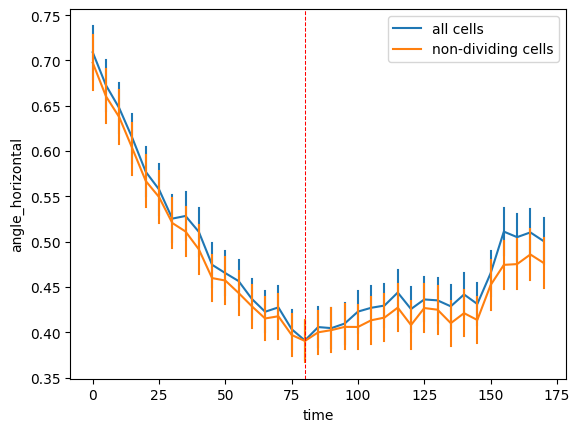

In [91]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
dat_df.tm_frame

0        0
1        0
2        0
3        0
4        0
        ..
7686    34
7687    34
7688    34
7689    34
7690    34
Name: tm_frame, Length: 7691, dtype: object

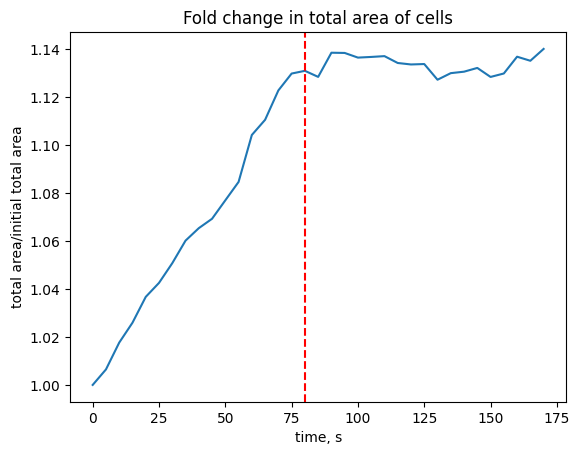

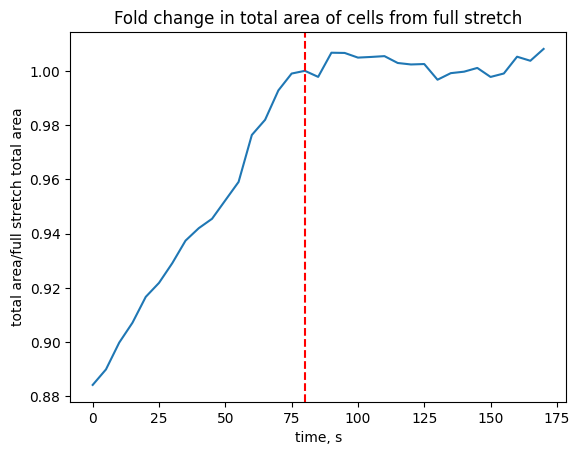

In [98]:
t=np.linspace(0, 170, 35)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

t=np.linspace(0, 170, 35)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==80].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/full stretch total area")
plt.title("Fold change in total area of cells from full stretch")
plt.savefig(plot_dir+'/total_area_full_stretch.png', dpi=300, bbox_inches='tight')

In [90]:
dat_df[dat_df.time==0].cell_area_microns

0      297.645585
1      396.177547
2      267.924949
3      228.980667
4      261.922259
          ...    
208    763.220087
209    627.500727
210    821.636510
211    665.273753
212    753.557220
Name: cell_area_microns, Length: 213, dtype: float64

In [99]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)

In [100]:
#dat_df[dat_df.cell_id_new==0].cell_area_microns/dat_df[dat_df.cell_id_new==0].cell_area_microns[0]
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

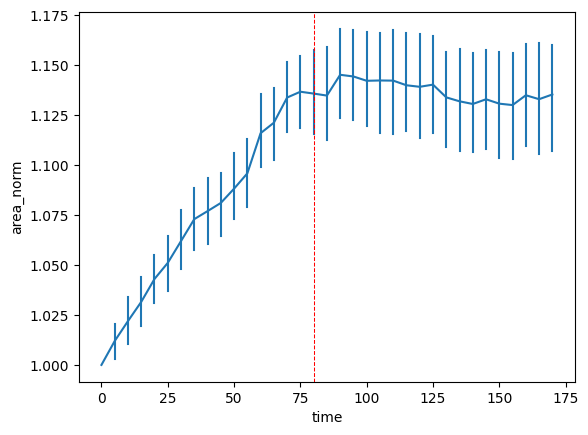

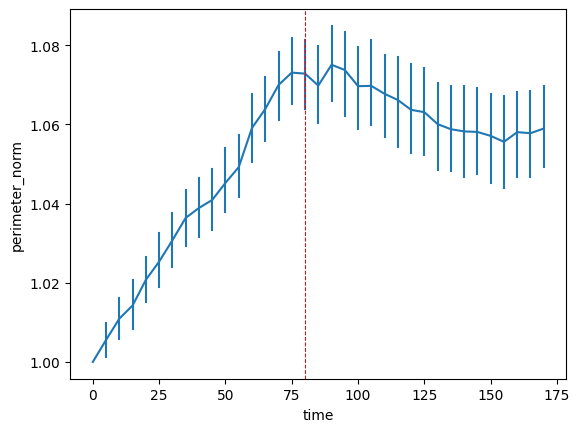

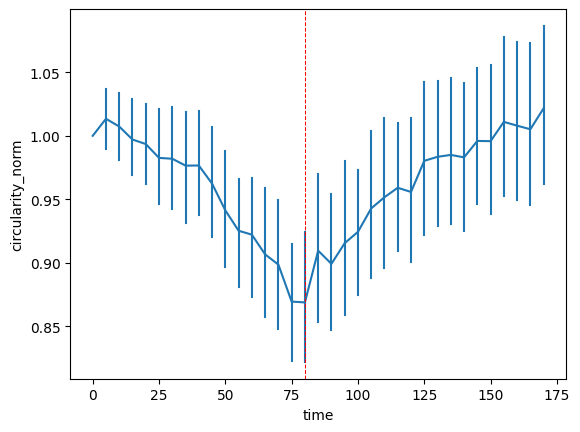

In [101]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity_norm', x='time',err_style='bars')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circ_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

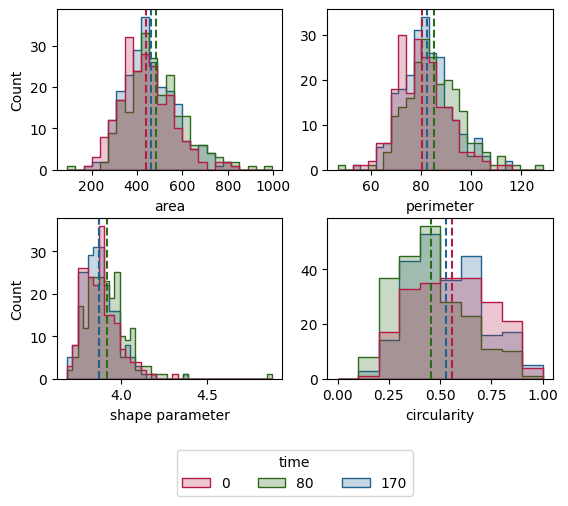

In [102]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==170].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='cell_perimeter_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==170].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='circularity', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==170].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==170)], hue='time',x='shape_parameter', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==170].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

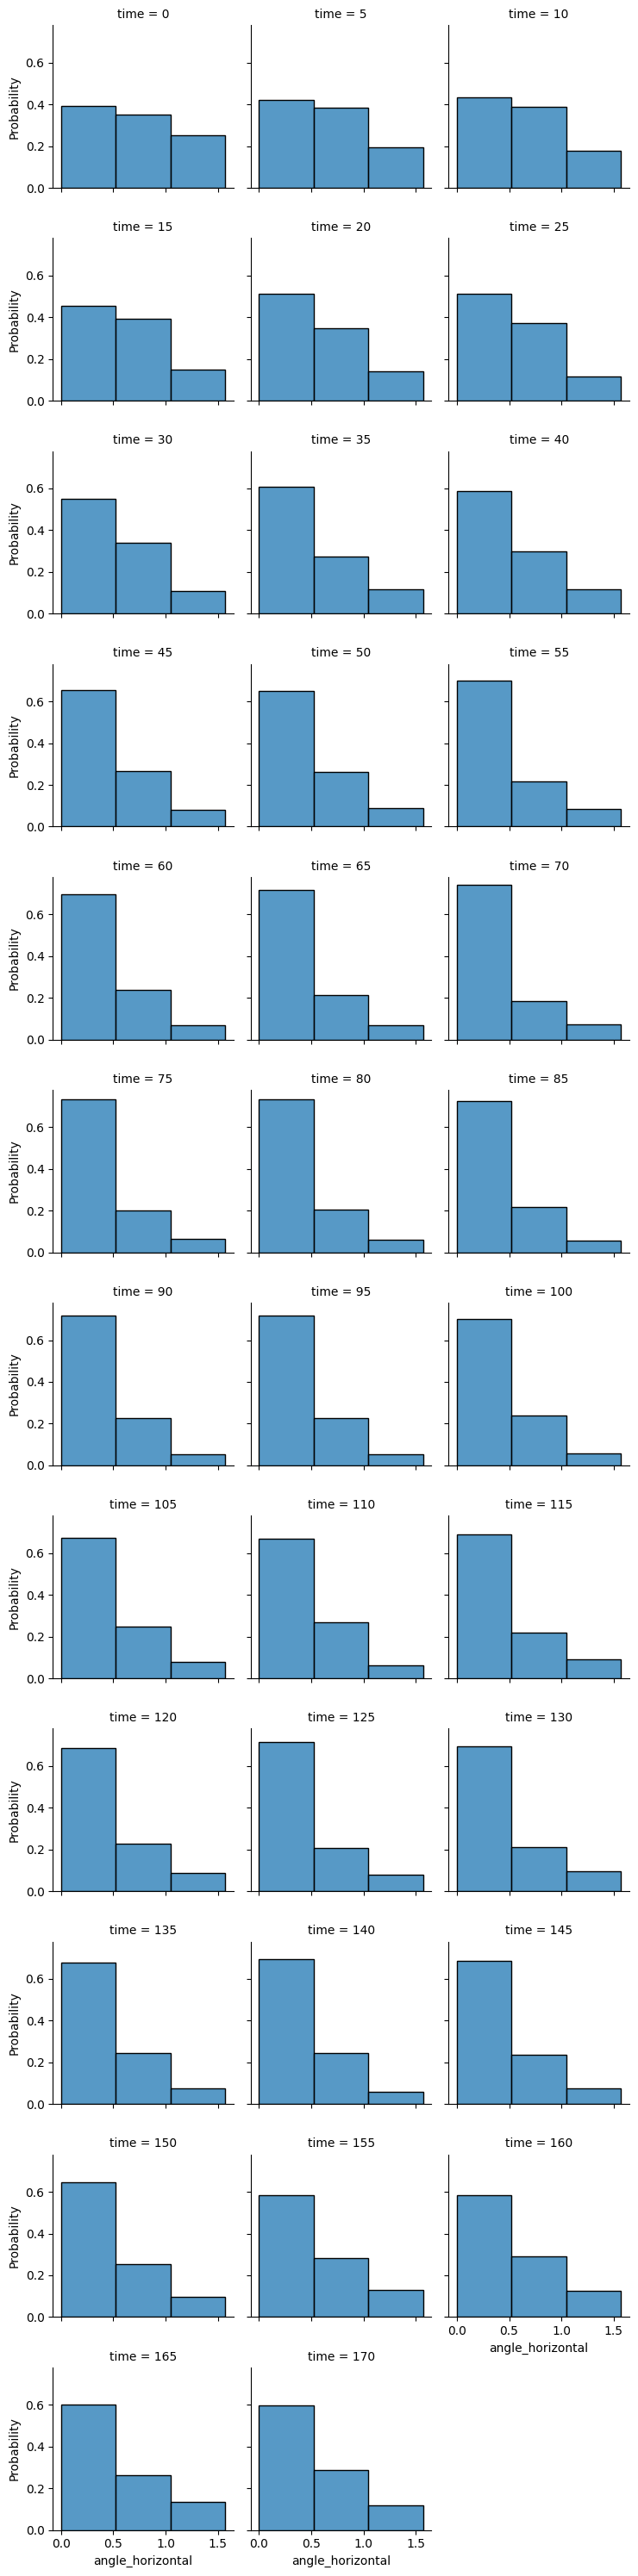

In [130]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

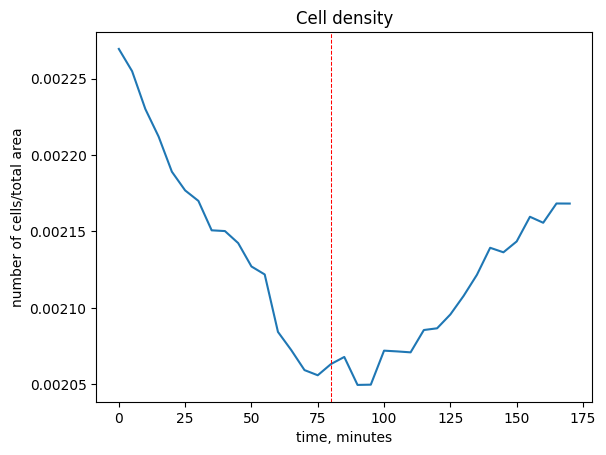

In [104]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')